### Basic Autoencoder

In this assignment, we will create a **simple autoencoder** model using the [TensorFlow subclassing API](https://www.tensorflow.org/guide/keras#model_subclassing). We start with the popular [MNIST dataset](http://yann.lecun.com/exdb/mnist/) (Grayscale images of hand-written digits from 0 to 9).
_[This first section is based on a notebook orignially contributed by: [afagarap](https://github.com/afagarap)]_

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.
 
 1) Autoencoders are _data-specific_, which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

2) Autoencoders are _lossy_, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

3) Autoencoders are _learned automatically from data examples_, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

To build an autoencoder, you need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function). The encoder and decoder will be chosen to be parametric functions (typically neural networks), and to be differentiable with respect to the distance function, so the parameters of the encoding/decoding functions can be optimize to minimize the reconstruction loss, using Stochastic Gradient Descent. 

In general, a neural network is a computational model that is used for finding a function describing the relationship between data features $x$ and its values or labels $y$, i.e. $y = f(x)$. 
An autoencoder is specific type of neural network, which consists of encoder and decoder components: (1) the **encoder**, which learns a compressed data representation $z$, and (2) the **decoder**, which reconstructs the data $\hat{x}$ based on its idea $z$ of how it is structured:
$$ z = f\big(h_{e}(x)\big)$$
$$ \hat{x} = f\big(h_{d}(z)\big),$$
where $z$ is the learned data representation by encoder $h_{e}$, and $\hat{x}$ is the reconstructed data by decoder $h_{d}$ based on $z$.

### Setup
We start by importing the libraries and functions that we will need.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

print('TensorFlow version:', tf.__version__)
print('Is Executing Eagerly?', tf.executing_eagerly())

TensorFlow version: 2.4.1
Is Executing Eagerly? True


### Autoencoder model

The encoder and decoder are defined as:
$$ z = f\big(h_{e}(x)\big)$$
$$ \hat{x} = f\big(h_{d}(z)\big),$$
where $z$ is the compressed data representation generated by encoder $h_{e}$, and $\hat{x}$ is the reconstructed data generated by decoder $h_{d}$ based on $z$.

<div align="center"><img src="https://github.com/benjaminirving/mlseminars-autoencoders/blob/master/imgs/d1.png?raw=1" width="80%"></div>

In this figure, we take as input an image, and compress that image before decompressing it using a Dense network. We further define a simple model for this below.

#### Define an encoder layer

The first component, the **encoder**, is similar to a conventional feed-forward network. However, it's function is not  predicting values (a _regression_ task) or categories (a _classification_ task). Instead, it's function is to learn a compressed data structure  $z$. We can implement the encoder layer as dense layers, as follows:

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
    
    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return self.output_layer(activation)

The encoding is done by passing data input  x  to the encoder's hidden layer  h  in order to learn the data representation  z=f(h(x)) .

We first create an Encoder class that inherits the tf.keras.layers.Layer class to define it as a layer. The compressed layer  z  is a component of the autoencoder model.

Analyzing the code, the Encoder layer is defined to have a single hidden layer of neurons (self.hidden_layer) to learn the input features. Then, we connect the hidden layer to a layer (self.output_layer) that encodes the learned activations to the lower dimensional layer for  z .

#### Define a decoder layer

The second component, the **decoder**, is also similar to a feed-forward network. However, instead of reducing data to lower dimension, it attempts to reverse the process, i.e. reconstruct the data $\hat{x}$ from its lower dimension representation $z$ to its original dimension.

The _decoding_ is done by passing the lower dimension representation $z$ to the decoder's hidden layer $h$ in order to reconstruct the data to its original dimension $\hat{x} = f(h(z))$. We can implement the decoder layer as follows,

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.relu)
  
    def call(self, code):
        activation = self.hidden_layer(code)
        return self.output_layer(activation)

We now create a `Decoder` class that also inherits the `tf.keras.layers.Layer`.

The `Decoder` layer is also defined to have a single hidden layer of neurons to reconstruct the input features $\hat{x}$ from the learned representation $z$ by the encoder $f\big(h_{e}(x)\big)$. Then, we connect its hidden layer to a layer that decodes the data representation from lower dimension $z$ to its original dimension $\hat{x}$. Hence, the "output" of the `Decoder` layer is the reconstructed data $\hat{x}$ from the data representation $z$.

Ultimately, the output of the decoder is the autoencoder's output.

Now that we have defined the components of our autoencoder, we can finally build our model.

#### Build the autoencoder model

We can now build the autoencoder model by instantiating `Encoder` and `Decoder` layers.

In [ ]:
class Autoencoder(tf.keras.Model):
    def __init__(self, intermediate_dim, original_dim):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(intermediate_dim=intermediate_dim)
        self.decoder = Decoder(intermediate_dim=intermediate_dim, original_dim=original_dim)

    def call(self, input_features):
        code = self.encoder(input_features)
        reconstructed = self.decoder(code)
        return reconstructed

As discussed above, the encoder's output is the input to the decoder, as it is written above (`reconstructed = self.decoder(code)`).

#### Reconstruction error

To learn the compressed layer $z$, we define a loss function over the difference between the input data $x$ and the reconstruction of $x$, which is $\hat{x}$.
We call this comparison the reconstruction error function, a given by the following equation:
$$ L = \dfrac{1}{n} \sum_{i=0}^{n-1} \big(\hat{x}_{i} - x_{i}\big)^{2}$$
where $\hat{x}$ is the reconstructed data while $x$ is the original data.

In [ ]:
def loss(preds, real):
    return tf.reduce_mean(tf.square(tf.subtract(preds, real)))

#### Forward pass and optimization

We will write a function for computing the forward pass, and applying a chosen optimization function.

In [ ]:
def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        preds = model(original)
        reconstruction_error = loss(preds, original)
    gradients = tape.gradient(reconstruction_error, model.trainable_variables)
    gradient_variables = zip(gradients, model.trainable_variables)
    opt.apply_gradients(gradient_variables)
  
    return reconstruction_error

#### The training loop

Finally, we will write a function to run the training loop. This function will take arguments for the model, the optimization function, the loss, the dataset, and the training epochs.

The training loop itself uses a `GradientTape` context defined in `train` for each batch.

In [ ]:
def train_loop(model, opt, loss, dataset, epochs):
    for epoch in range(epochs):
        epoch_loss = 0
        for step, batch_features in enumerate(dataset):
            loss_values = train(loss, model, opt, batch_features)
            epoch_loss += loss_values
        model.loss.append(epoch_loss)
        print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

#### Process the dataset

Now that we have defined our `Autoencoder` class, the loss function, and the training loop, let's import the dataset. We will normalize the pixel values for each example through dividing by maximum pixel value. We shall flatten the examples from 28 by 28 arrays to 784-dimensional vectors.

In [ ]:
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255

x_train = x_train.astype(np.float32)
x_test = x_train.astype(np.float32)
x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))

training_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(256)

11493376/11490434 [==============================] - 0s 0us/step


#### Train the model

Now all we have to do is instantiate the autoencoder model and choose an optimization function, then pass the intermediate dimension and the original dimension of the images.

In [ ]:
model = Autoencoder(intermediate_dim=128, original_dim=784)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(model, opt, loss, training_dataset, 20)

Epoch 1/20. Loss: 8.42420482635498
Epoch 2/20. Loss: 5.4199676513671875
Epoch 3/20. Loss: 4.871105670928955
Epoch 4/20. Loss: 4.589909076690674
Epoch 5/20. Loss: 4.424950122833252
Epoch 6/20. Loss: 4.3090901374816895
Epoch 7/20. Loss: 4.22543478012085
Epoch 8/20. Loss: 4.211780071258545
Epoch 9/20. Loss: 4.151665210723877
Epoch 10/20. Loss: 4.145687580108643
Epoch 11/20. Loss: 4.13097620010376
Epoch 12/20. Loss: 4.100851058959961
Epoch 13/20. Loss: 4.051158905029297
Epoch 14/20. Loss: 4.07196569442749
Epoch 15/20. Loss: 4.0263991355896
Epoch 16/20. Loss: 4.030947208404541
Epoch 17/20. Loss: 4.015335559844971
Epoch 18/20. Loss: 4.007718086242676
Epoch 19/20. Loss: 3.9987382888793945
Epoch 20/20. Loss: 4.016757965087891


#### Plot the in-training performance

Let's take a look at how the model performed during training in a couple of plots.

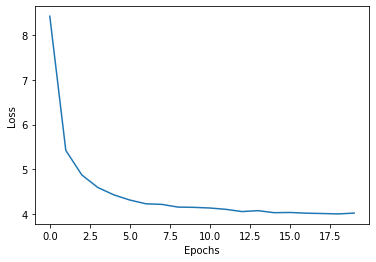

In [ ]:
plt.plot(range(20), model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#### Predictions

Finally, we will look at some of the predictions. The wrong predictions are labeled in red.

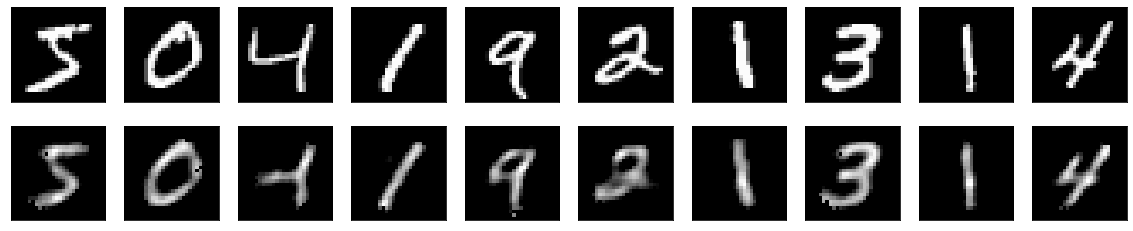

In [ ]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 1. Tasks for Basic Autoencoder

After training this model, the reconstructed images are quite blurry. A number of things could be done to move forward from this point, e.g. adding more layers, or using a convolutional neural network architecture as the basis of the autoencoder, or use a different kind of autoencoder.


### Dense Multi layer Models

In [ ]:
import keras
from keras import layers

#### Processing dataset

We will normalize the pixel values between 0 and 1 and we will flatten the examples from 28 by 28 arrays to 784-dimensional vectors.

In [ ]:
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype(np.float32)/ 255.
x_test = x_test.astype(np.float32) / 255.

x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))

11493376/11490434 [==============================] - 0s 0us/step


#### Model 1

##### Encoder layer

Multiple layers without regularizer

In [ ]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

##### Decoder Layer

In [ ]:
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

##### Model With loss funtion MSE run for 100 epochs

In [ ]:
autoencoder = keras.Model(input_img, decoded)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

autoencoder.compile(optimizer=opt, loss='mse')

history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 4s 14ms/step - loss: 0.0683 - val_loss: 0.0300
Epoch 2/100
235/235 [==============================] - 3s 12ms/step - loss: 0.0280 - val_loss: 0.0226
Epoch 3/100
235/235 [==============================] - 3s 12ms/step - loss: 0.0217 - val_loss: 0.0191
Epoch 4/100
235/235 [==============================] - 3s 12ms/step - loss: 0.0184 - val_loss: 0.0164
Epoch 5/100
235/235 [==============================] - 3s 12ms/step - loss: 0.0166 - val_loss: 0.0153
Epoch 6/100
235/235 [==============================] - 3s 12ms/step - loss: 0.0157 - val_loss: 0.0147
Epoch 7/100
235/235 [==============================] - 3s 12ms/step - loss: 0.0151 - val_loss: 0.0144
Epoch 8/100
235/235 [==============================] - 3s 12ms/step - loss: 0.0145 - val_loss: 0.0140
Epoch 9/100
235/235 [==============================] - 3s 12ms/step - loss: 0.0142 - val_loss: 0.0136
Epoch 10/100
235/235 [==============================] - 3s 12ms/step - loss: 0.013

##### Plot in Training performance

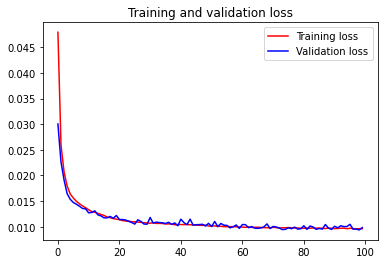

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Error calculation

In [ ]:
import math

reconstr_error = autoencoder.evaluate( x_test, x_test, verbose=0)
print('The reconstruction error: MSE - %.4f, RMSE - %.4f ' % (reconstr_error , math.sqrt(reconstr_error)))

The reconstruction error: MSE - 0.0098, RMSE - 0.0991 


##### Prediction

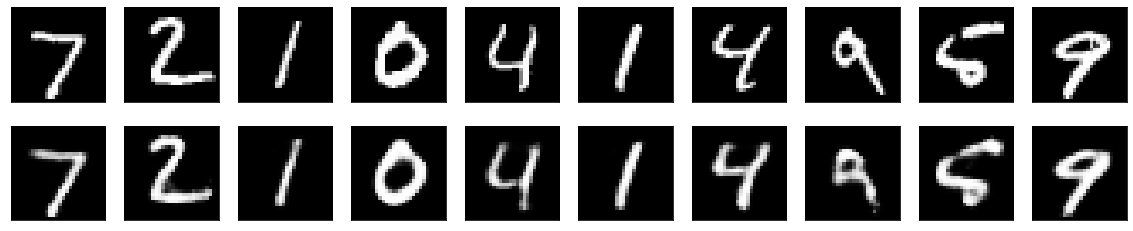

In [ ]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(autoencoder(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Model 2

##### Encoder layer

Multiple layers to the dense arcitechture with L1 regularizer

In [ ]:
from keras import regularizers

input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(input_img)
encoded = layers.Dense(32, activation='relu',activity_regularizer=regularizers.l1(10e-5))(encoded)

##### Decoder Layer

In [ ]:
decoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(128, activation='relu')(input_img)
decoded = layers.Dense(784, activation='relu')(decoded)

##### Model With loss funtion MSE, run for 100 epochs

In [ ]:
autoencoder = keras.Model(input_img, decoded)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

autoencoder.compile(optimizer=opt, loss='mse')

history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 1s 5ms/step - loss: 0.0489 - val_loss: 0.0272
Epoch 2/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0266 - val_loss: 0.0249
Epoch 3/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0247 - val_loss: 0.0240
Epoch 4/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0240 - val_loss: 0.0231
Epoch 5/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0236 - val_loss: 0.0230
Epoch 6/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0233 - val_loss: 0.0229
Epoch 7/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0229 - val_loss: 0.0224
Epoch 8/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0225 - val_loss: 0.0218
Epoch 9/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0223 - val_loss: 0.0220
Epoch 10/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0222 - val_lo

##### Plot in Training performance

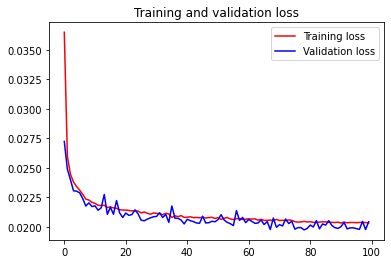

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Error calculation

In [ ]:
import math

reconstr_error = autoencoder.evaluate( x_test, x_test, verbose=0)
print('The reconstruction error: MSE - %.4f, RMSE - %.4f ' % (reconstr_error , math.sqrt(reconstr_error)))

The reconstruction error: MSE - 0.0204, RMSE - 0.1429 


##### Prediction

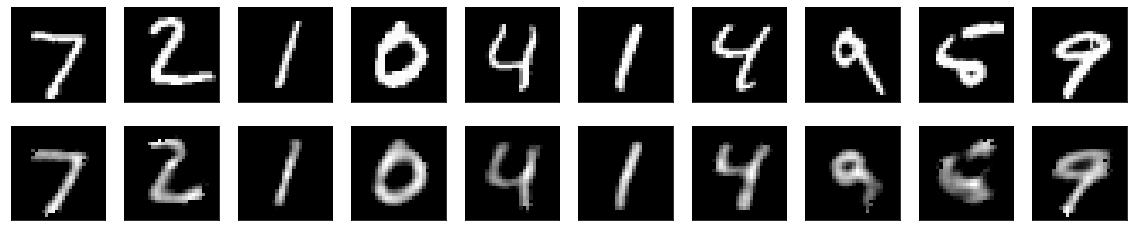

In [ ]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(autoencoder(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Model 3

##### Encoder layer

Multiple layers to the dense arcitechture with L2 regularizer

In [ ]:
from keras import regularizers

input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(input_img)
encoded = layers.Dense(32, activation='relu',activity_regularizer=regularizers.l2(10e-5))(encoded)

##### Decoder Layer

In [ ]:
decoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(128, activation='relu')(input_img)
decoded = layers.Dense(784, activation='relu')(decoded)

##### Model With loss funtion MSE, run for 100 epochs

In [ ]:
autoencoder = keras.Model(input_img, decoded)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

autoencoder.compile(optimizer=opt, loss='mse')

history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 2s 5ms/step - loss: 0.0576 - val_loss: 0.0333
Epoch 2/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0328 - val_loss: 0.0305
Epoch 3/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0309 - val_loss: 0.0304
Epoch 4/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0302 - val_loss: 0.0299
Epoch 5/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0297 - val_loss: 0.0291
Epoch 6/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0292 - val_loss: 0.0287
Epoch 7/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0291 - val_loss: 0.0290
Epoch 8/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0288 - val_loss: 0.0290
Epoch 9/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0288 - val_loss: 0.0282
Epoch 10/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0286 - val_lo

##### Plot in Training performance

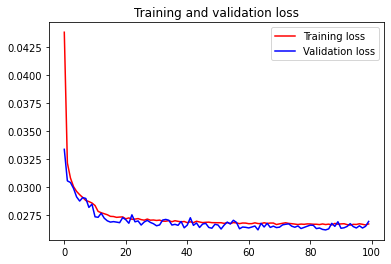

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Error calculation

In [ ]:
import math

reconstr_error = autoencoder.evaluate( x_test, x_test, verbose=0)
print('The reconstruction error: MSE - %.4f, RMSE - %.4f ' % (reconstr_error , math.sqrt(reconstr_error)))

The reconstruction error: MSE - 0.0269, RMSE - 0.1640 


##### Prediction

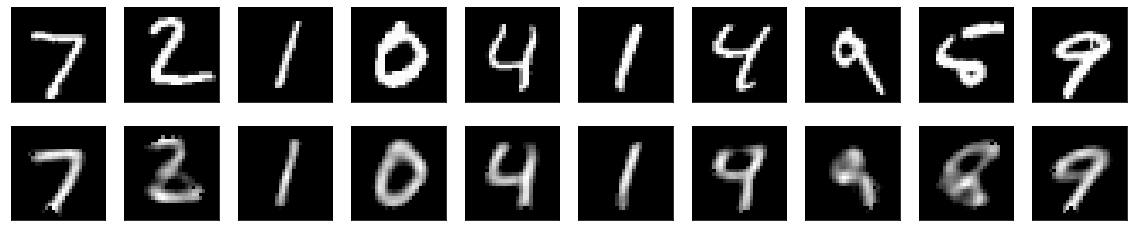

In [ ]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(autoencoder(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### CNN basic model
One can use convolutional layers in an autoencoder when the inputs are structured.

Since our inputs are images, it makes sense to use convolutional neural networks (CNNs) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders -- they simply perform much better.

- implement a CNN model, where the encoder will consist of a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers. To improve the quality of the reconstructed image, we use more filters per layer. The model details are:

In [ ]:
input_img = tf.keras.layers.Input(shape=(28, 28, 1)) 

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
# we will train this model with original MNIST digits with shape (samples, 3, 28, 28) 
# and we will just normalize pixel values between 0 and 1
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

#### Model is run for 100 epochs

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=128, 
                shuffle=True, validation_data=(x_test, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/autoencoder')])

Epoch 1/100
469/469 [==============================] - 5s 8ms/step - loss: 0.6914 - val_loss: 0.6891
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.6881 - val_loss: 0.6849
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.6835 - val_loss: 0.6788
Epoch 4/100
469/469 [==============================] - 3s 6ms/step - loss: 0.6765 - val_loss: 0.6685
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.6640 - val_loss: 0.6465
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.6343 - val_loss: 0.5787
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.5509 - val_loss: 0.5019
Epoch 8/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4940 - val_loss: 0.4848
Epoch 9/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4777 - val_loss: 0.4722
Epoch 10/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4658 - val_lo

#### Plot the in-training performance


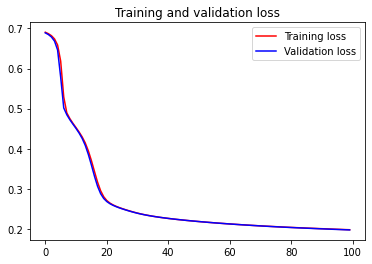

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Error calculation

In [ ]:
import math

reconstr_error = autoencoder.evaluate( x_test, x_test, verbose=0)
print('The reconstruction error: MSE - %.4f, RMSE - %.4f ' % (reconstr_error , math.sqrt(reconstr_error)))

The reconstruction error: MSE - 0.1974, RMSE - 0.4443 


#### Predictions

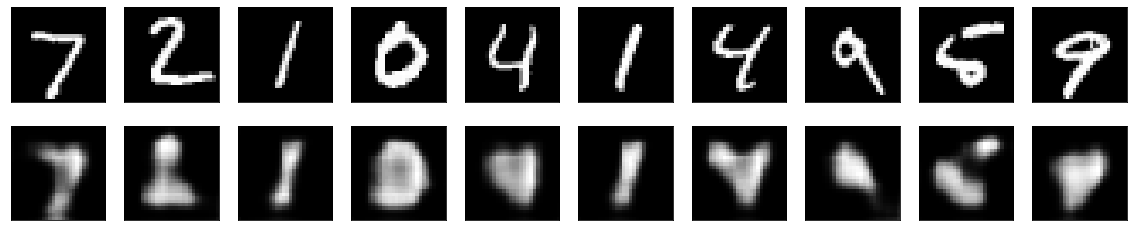

In [ ]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(autoencoder(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### CNN Complex models



#### Model 1


In [ ]:
from keras import regularizers
from keras.layers.normalization import BatchNormalization

input_img = tf.keras.layers.Input(shape=(28, 28, 1)) 

conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28*28*32
conv1 = BatchNormalization()(conv1)
conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
conv2 = BatchNormalization()(conv2)
pool1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(conv2) #14*14*32
conv3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(pool1) #14*14*16
conv3 = BatchNormalization()(conv3)
conv4 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv3)
conv4 = BatchNormalization()(conv4)
pool2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(conv4) #7*7*16
encoded = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', activity_regularizer=regularizers.l1(10e-5), padding='same')(pool2)
encoded = BatchNormalization()(encoded)

# at this point the representation is (7, 7, 8) i.e. 392-dimensional , 

conv5 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
conv5 = BatchNormalization()(conv5)
conv6 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv5) #7*7*16
conv6 = BatchNormalization()(conv6)
conv7 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv6)
conv7 = BatchNormalization()(conv7)
up1 = tf.keras.layers.UpSampling2D((2, 2))(conv7)
conv8 = tf.keras.layers.Conv2D(32, (1, 1), activation='relu')(up1)
conv8 = BatchNormalization()(conv8)
conv9 = tf.keras.layers.Conv2D(32, (1, 1), activation='relu')(conv8)
conv9 = BatchNormalization()(conv9)
up2 = tf.keras.layers.UpSampling2D((2, 2))(conv9)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')
autoencoder.summary()

Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_175 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_31 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_176 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_32 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 14, 14, 16)        462

In [ ]:
# we will train this model with original MNIST digits with shape (samples, 3, 28, 28) 
# and we will just normalize pixel values between 0 and 1
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

##### Model train for 100 epochs

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=128,
                shuffle=True, validation_data=(x_test, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/autoencoder')])

Epoch 1/100
469/469 [==============================] - 9s 15ms/step - loss: 0.3282 - val_loss: 0.3577
Epoch 2/100
469/469 [==============================] - 5s 12ms/step - loss: 0.3106 - val_loss: 0.3016
Epoch 3/100
469/469 [==============================] - 5s 12ms/step - loss: 0.2958 - val_loss: 0.2856
Epoch 4/100
469/469 [==============================] - 6s 12ms/step - loss: 0.2830 - val_loss: 0.2739
Epoch 5/100
469/469 [==============================] - 5s 12ms/step - loss: 0.2712 - val_loss: 0.2633
Epoch 6/100
469/469 [==============================] - 6s 12ms/step - loss: 0.2604 - val_loss: 0.2530
Epoch 7/100
469/469 [==============================] - 5s 12ms/step - loss: 0.2502 - val_loss: 0.2434
Epoch 8/100
469/469 [==============================] - 6s 12ms/step - loss: 0.2402 - val_loss: 0.2342
Epoch 9/100
469/469 [==============================] - 6s 12ms/step - loss: 0.2307 - val_loss: 0.2248
Epoch 10/100
469/469 [==============================] - 6s 12ms/step - loss: 0.221

##### Plot the in-training performance


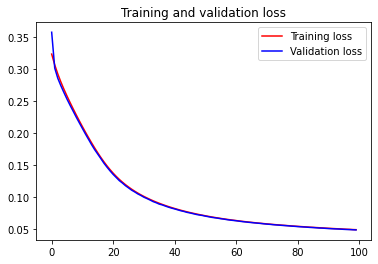

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Error calculation

In [ ]:
import math

reconstr_error = autoencoder.evaluate( x_test, x_test, verbose=0)
print('The reconstruction error: MSE - %.4f, RMSE - %.4f ' % (reconstr_error , math.sqrt(reconstr_error)))

The reconstruction error: MSE - 0.0485, RMSE - 0.2202 


##### Predictions

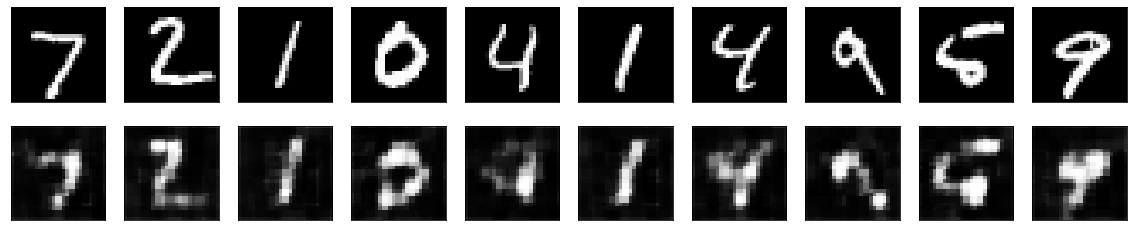

In [ ]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(autoencoder(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Model 2

In [ ]:
from keras import regularizers
from keras.layers.normalization import BatchNormalization

input_img = tf.keras.layers.Input(shape=(28, 28, 1)) 

# encoder
conv1 = tf.keras.layers.Conv2D(32, (11, 11), activation='relu', padding='same')(input_img) 
conv1 = BatchNormalization()(conv1)
pool1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(conv1) 
conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1) 
conv2 = BatchNormalization()(conv2)
pool2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(conv2) 
conv3 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')(pool2)
conv3 = BatchNormalization()(conv3)
pool3 = tf.keras.layers.MaxPooling2D((3, 3), padding='same')(conv3) 
conv4 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', activity_regularizer=regularizers.l2(10e-5), padding='same')(pool3)
encoded = BatchNormalization()(conv4)


# decoder
conv5 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
conv5 = BatchNormalization()(conv5)
conv6 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')(conv5) 
conv6 = BatchNormalization()(conv6)
up1 = tf.keras.layers.UpSampling2D((3, 3))(conv6)
conv7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
conv7 = BatchNormalization()(conv7)
up2 = tf.keras.layers.UpSampling2D((2, 2))(conv7)
conv8 = tf.keras.layers.Conv2D(32, (5,5), activation='relu')(up2)
conv8 = BatchNormalization()(conv8)
up3 = tf.keras.layers.UpSampling2D((2, 2))(conv8)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 28, 28, 32)        3904      
_________________________________________________________________
batch_normalization_73 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_222 (Conv2D)          (None, 14, 14, 128)       36992     
_________________________________________________________________
batch_normalization_74 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 7, 7, 128)         0  

In [ ]:
# we will train this model with original MNIST digits with shape (samples, 3, 28, 28) 
# and we will just normalize pixel values between 0 and 1
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

##### Model training run for 100 epochs

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=128,
                shuffle=True, validation_data=(x_test, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/autoencoder')])

Epoch 1/100
469/469 [==============================] - 12s 23ms/step - loss: 0.0726 - val_loss: 0.0279
Epoch 2/100
469/469 [==============================] - 10s 21ms/step - loss: 0.0175 - val_loss: 0.0134
Epoch 3/100
469/469 [==============================] - 10s 21ms/step - loss: 0.0128 - val_loss: 0.0119
Epoch 4/100
469/469 [==============================] - 10s 21ms/step - loss: 0.0108 - val_loss: 0.0119
Epoch 5/100
469/469 [==============================] - 10s 21ms/step - loss: 0.0097 - val_loss: 0.0109
Epoch 6/100
469/469 [==============================] - 10s 21ms/step - loss: 0.0088 - val_loss: 0.0101
Epoch 7/100
469/469 [==============================] - 10s 21ms/step - loss: 0.0084 - val_loss: 0.0100
Epoch 8/100
469/469 [==============================] - 10s 21ms/step - loss: 0.0079 - val_loss: 0.0114
Epoch 9/100
469/469 [==============================] - 10s 21ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 10/100
469/469 [==============================] - 10s 21ms/step - l

##### Plot the in-training performance


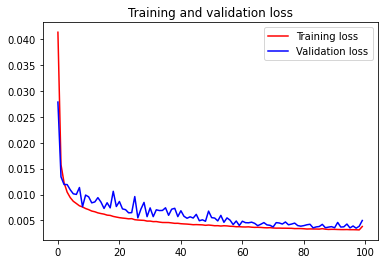

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Error calculation

In [ ]:
import math

reconstr_error = autoencoder.evaluate( x_test, x_test, verbose=0)
print('The reconstruction error: MSE - %.4f, RMSE - %.4f ' % (reconstr_error , math.sqrt(reconstr_error)))

The reconstruction error: MSE - 0.0050, RMSE - 0.0706 


##### Predictions

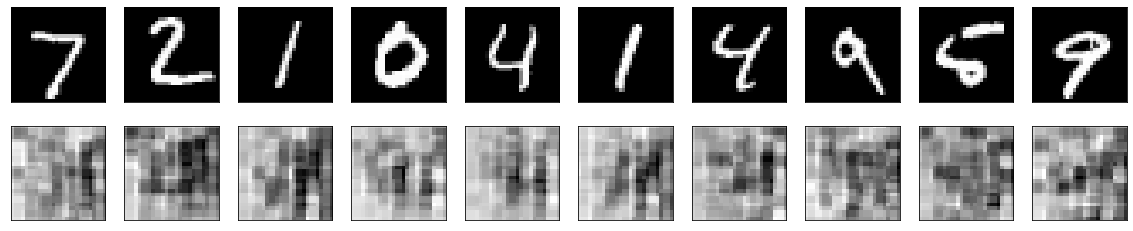

In [ ]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(cnn_autoencoder(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Model 3

In [ ]:
from keras import regularizers
from keras.layers.normalization import BatchNormalization

input_img = tf.keras.layers.Input(shape=(28, 28, 1)) 

# encoder
conv1 = tf.keras.layers.Conv2D(32, (11, 11), activation='relu', padding='same')(input_img) 
conv1 = BatchNormalization()(conv1)
pool1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(conv1) 
conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1) 
conv2 = BatchNormalization()(conv2)
pool2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(conv2) 
conv3 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')(pool2)
conv3 = BatchNormalization()(conv3)
pool3 = tf.keras.layers.MaxPooling2D((3, 3), padding='same')(conv3) 
conv4 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', activity_regularizer=regularizers.l2(10e-5), padding='same')(pool3)
encoded = BatchNormalization()(conv4)


# decoder
conv5 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
conv5 = BatchNormalization()(conv5)
conv6 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')(conv5) 
conv6 = BatchNormalization()(conv6)
up1 = tf.keras.layers.UpSampling2D((3, 3))(conv6)
conv7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
conv7 = BatchNormalization()(conv7)
up2 = tf.keras.layers.UpSampling2D((2, 2))(conv7)
conv8 = tf.keras.layers.Conv2D(32, (5,5), activation='relu')(up2)
conv8 = BatchNormalization()(conv8)
up3 = tf.keras.layers.UpSampling2D((2, 2))(conv8)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        3904      
_________________________________________________________________
batch_normalization_8 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 128)       36992     
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 128)         0   

In [ ]:
# we will train this model with original MNIST digits with shape (samples, 3, 28, 28) 
# and we will just normalize pixel values between 0 and 1
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

##### Model training run for 100 epochs

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=128,
                shuffle=True, validation_data=(x_test, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/autoencoder')])

Epoch 1/100
469/469 [==============================] - 12s 24ms/step - loss: 0.8182 - val_loss: 0.6856
Epoch 2/100
469/469 [==============================] - 10s 22ms/step - loss: 0.7010 - val_loss: 0.6679
Epoch 3/100
469/469 [==============================] - 10s 22ms/step - loss: 0.6480 - val_loss: 0.6334
Epoch 4/100
469/469 [==============================] - 10s 21ms/step - loss: 0.6144 - val_loss: 0.6037
Epoch 5/100
469/469 [==============================] - 10s 21ms/step - loss: 0.5905 - val_loss: 0.5821
Epoch 6/100
469/469 [==============================] - 10s 21ms/step - loss: 0.5724 - val_loss: 0.5639
Epoch 7/100
469/469 [==============================] - 10s 21ms/step - loss: 0.5574 - val_loss: 0.5490
Epoch 8/100
469/469 [==============================] - 10s 21ms/step - loss: 0.5434 - val_loss: 0.5361
Epoch 9/100
469/469 [==============================] - 10s 21ms/step - loss: 0.5315 - val_loss: 0.5247
Epoch 10/100
469/469 [==============================] - 10s 21ms/step - l

##### Plot the in-training performance


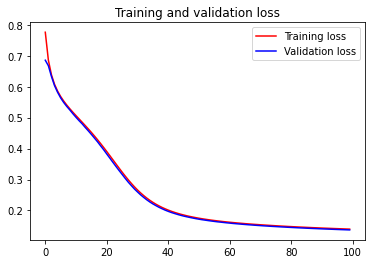

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Error calculation

In [ ]:
import math

reconstr_error = autoencoder.evaluate( x_test, x_test, verbose=0)
print('The reconstruction error: MSE - %.4f, RMSE - %.4f ' % (reconstr_error , math.sqrt(reconstr_error)))

The reconstruction error: MSE - 0.1371, RMSE - 0.3702 


##### Predictions

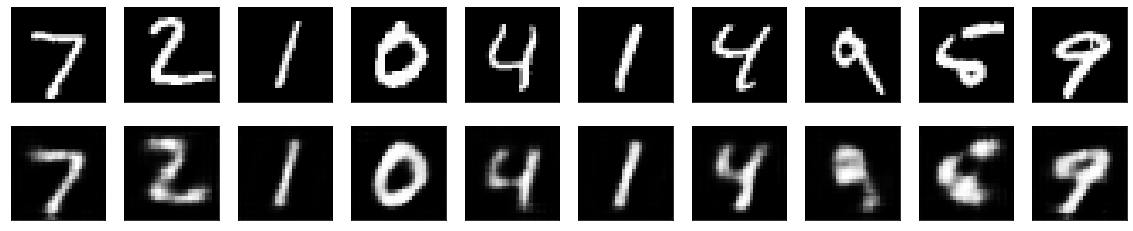

In [ ]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(autoencoder(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Table to compare different arcitectures

| Model Architecture | MSE | RMSE | COMMENTS |
| :- | :-:| :-:| :- |
| DENSE MULTI LAYER MODEL 1 | 0.0098 | 0.0991 |  |
| DENSE MULTI LAYER MODEL 2 (L1 Regularizer) | 0.0204| 0.1429 | |
| DENSE MULTI LAYER MODEL 3 (L2 Regularizer) | 0.0269| 0.1640 | |
| CNN Basic Model | 0.1974 | 0.4443 | |
| CNN Complex Model 1| 0.0485| 0.2202 | |
| CNN Complex Model 2| 0.0050| 0.0706 | Prediction image is blurry of "adam" optimizer compared to "adadelta" optimizer|
| CNN Complex Model 3| 0.1371| 0.3702 | |


### REPORT

Three dense multi layer models were executed with different sizes of dense layers. From the above table, we can that dense multi layer model 1 without regularizer performed better than the other two dense multi layer models with regularizer.

Two different optimizers "adam" and "adadelta" have been used in this experiment. Adadelta performed better than adam optimizer.

For the MNIST data set with handwritten images, among the models that were implemented to reconstruct the images, dense multi layer models performed better than CNN.

The CNN complex model 3 with loss function binary cross entropy and "adadelta" optimizer and "L2 Regularizer" performed the best among the other CNN complex models.

Overall, comparing the prediction for the models implemented above, dense multi layer model 1 without any regularizer performed the best in image reconstruction.

## 2. Denoising autoencoder

For this real-world application, we will use an autoencoder to remove noise from an image. To do this, we

- learn a more robust representation by forcing the autoencoder to learn an input from a corrupted version of itself

<div align="center"><img src="https://github.com/benjaminirving/mlseminars-autoencoders/blob/master/imgs/d3.png?raw=1" width="60%"></div>

### Dense, multi-layer models

In [ ]:
import keras
from keras import layers

#### Generate noise in data


In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train / 255.

x_train = x_train.astype(np.float32)
x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))

# Introduce noise
x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

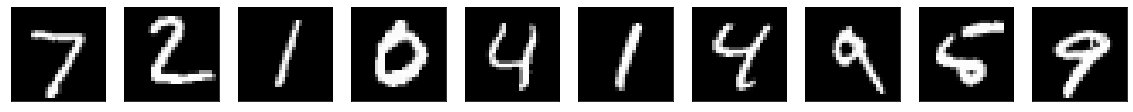

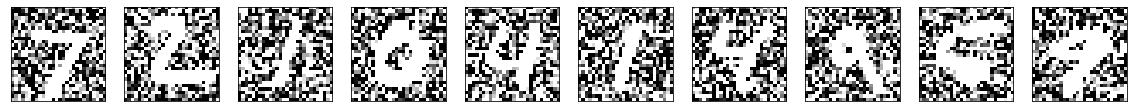

In [ ]:
# Plot figures to show what the noisy digits look like
n = 10
plt.figure(figsize=(20, 4))
for index in range(n):
    # display original
    ax = plt.subplot(2, n, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


#### Model 1

##### Encoder 

In [ ]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

##### Decoder 

In [ ]:
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

##### Model With loss funtion MSE run for 100 epochs

In [ ]:
autoencoder = keras.Model(input_img, decoded)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

autoencoder.compile(optimizer=opt, loss='mse')

history = autoencoder.fit(x_train_noisy, x_train, epochs=100, batch_size=256, 
                shuffle=True, validation_data=(x_test_noisy, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/100
235/235 [==============================] - 2s 7ms/step - loss: 0.1892 - val_loss: -91.3214
Epoch 2/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1816 - val_loss: -79.7475
Epoch 3/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1820 - val_loss: -77.9467
Epoch 4/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1821 - val_loss: -88.9699
Epoch 5/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1808 - val_loss: -79.0489
Epoch 6/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1819 - val_loss: -97.8852
Epoch 7/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1816 - val_loss: -89.9777
Epoch 8/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1818 - val_loss: -94.2087
Epoch 9/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1814 - val_loss: -93.8751
Epoch 10/100
235/235 [==============================] - 1s 4ms/step - los

##### Plot in Training performance

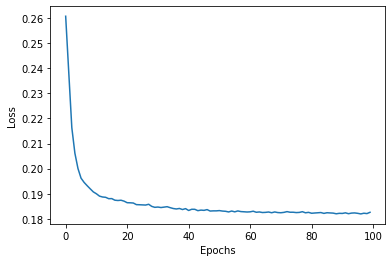

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Error calculation

In [ ]:
import math

reconstr_error = autoencoder.evaluate( x_test, x_test, verbose=0)
print('The reconstruction error: MSE - %.4f, RMSE - %.4f ' % (reconstr_error , math.sqrt(reconstr_error)))

The reconstruction error: MSE - 0.0269, RMSE - 0.1640 


##### Prediction

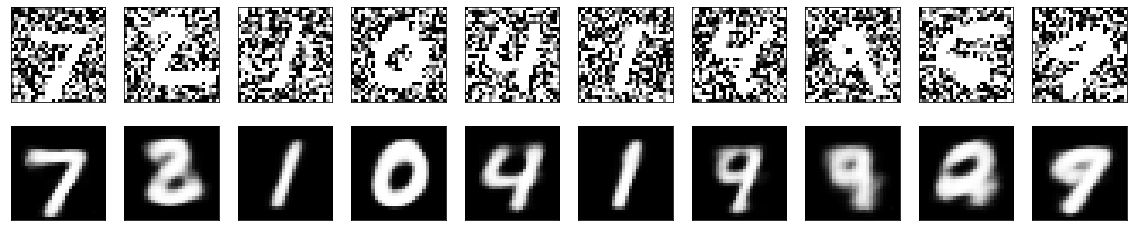

In [ ]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test_noisy[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(autoencoder(x_test_noisy)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Model 2

With L2 regularizer

##### Encoder layer

In [ ]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu', activity_regularizer=regularizers.l2(10e-5))(encoded)

##### Decoder Layer

In [ ]:
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

##### Model With loss funtion MSE run for 100 epochs

In [ ]:
autoencoder = keras.Model(input_img, decoded)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

autoencoder.compile(optimizer=opt, loss='mse')

history = autoencoder.fit(x_train_noisy, x_train, epochs=100, batch_size=256, 
                shuffle=True, validation_data=(x_test_noisy, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/100
235/235 [==============================] - 2s 7ms/step - loss: 0.2863 - val_loss: 8.7145
Epoch 2/100
235/235 [==============================] - 1s 4ms/step - loss: 0.2345 - val_loss: -4.8729
Epoch 3/100
235/235 [==============================] - 1s 4ms/step - loss: 0.2124 - val_loss: -20.8810
Epoch 4/100
235/235 [==============================] - 1s 4ms/step - loss: 0.2054 - val_loss: -27.9688
Epoch 5/100
235/235 [==============================] - 1s 4ms/step - loss: 0.2016 - val_loss: -32.5244
Epoch 6/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1994 - val_loss: -38.8695
Epoch 7/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1981 - val_loss: -36.1228
Epoch 8/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1981 - val_loss: -45.6586
Epoch 9/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1968 - val_loss: -43.9155
Epoch 10/100
235/235 [==============================] - 1s 4ms/step - loss: 

##### Plot in Training performance

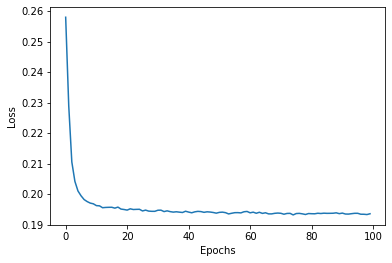

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Error calculation

In [ ]:
import math

reconstr_error = autoencoder.evaluate( x_test, x_test, verbose=0)
print('The reconstruction error: MSE - %.4f, RMSE - %.4f ' % (reconstr_error , math.sqrt(reconstr_error)))

The reconstruction error: MSE - 0.0269, RMSE - 0.1640 


##### Prediction

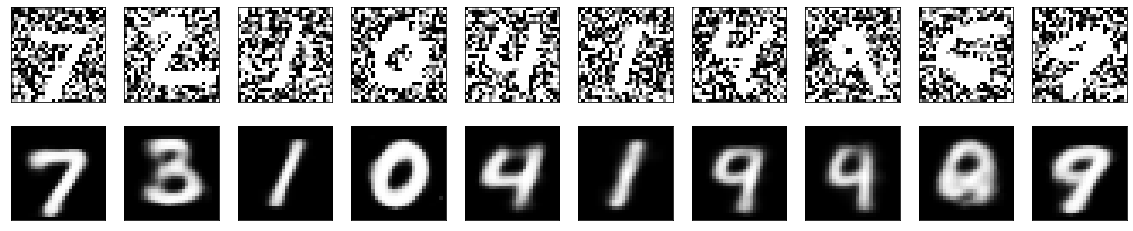

In [ ]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test_noisy[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(autoencoder2(x_test_noisy)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### CNN basic model

#### Generate noisy data for CNN

The first step: generate synthetic noisy digits as follows: apply a gaussian noise matrix and clip the images between 0 and 1.

In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Introduce noise with a probability factor of 0.5
noise_factor = 0.5
x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Next, plot some figures to see what the digits look like with noise added

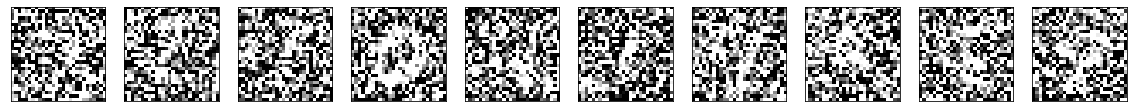

In [ ]:
# Plot figures to show what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Model Training
Train the model for 100 epochs and compare the results to the model where you use a dense encoding rather than convolutions.

In [ ]:
input_img = tf.keras.layers.Input(shape=(28, 28, 1)) # adapt this if using `channels_first` image data format

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')

In [ ]:
# This will train for 100 epochs
history = autoencoder.fit(x_train_noisy, x_train, epochs=100, batch_size=128, 
                shuffle=True, validation_data=(x_test_noisy, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/100
469/469 [==============================] - 37s 9ms/step - loss: 0.2329 - val_loss: 0.2322
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2318 - val_loss: 0.2310
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2305 - val_loss: 0.2296
Epoch 4/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2292 - val_loss: 0.2281
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2276 - val_loss: 0.2263
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2255 - val_loss: 0.2239
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2230 - val_loss: 0.2207
Epoch 8/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2195 - val_loss: 0.2162
Epoch 9/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2145 - val_loss: 0.2092
Epoch 10/100
469/469 [==============================] - 3s 6ms/step - loss: 0.2064 - val_l

#### Plot the in-training performance

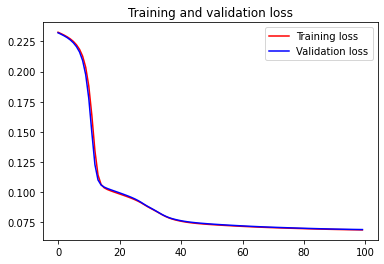

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Error calculation

In [ ]:
import math

reconstr_error = autoencoder.evaluate( x_test, x_test, verbose=0)
print('The reconstruction error: MSE - %.4f, RMSE - %.4f ' % (reconstr_error , math.sqrt(reconstr_error)))

The reconstruction error: MSE - 0.0886, RMSE - 0.2976 


#### Predictions

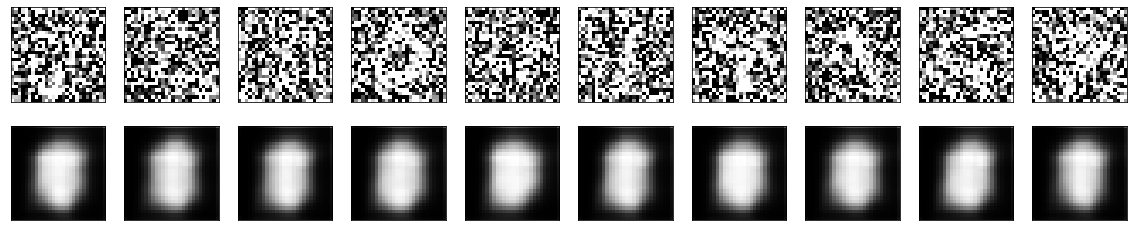

In [ ]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test_noisy[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(autoencoder(x_test_noisy)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### CNN complex model

In [ ]:
import keras
from keras import layers
from keras.layers.normalization import BatchNormalization

input_img = tf.keras.layers.Input(shape=(28, 28, 1)) 


x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = BatchNormalization()(x)



x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 128)       1280      
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 32)        36896     
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 32)        9248

#### Model Training

In [ ]:
# This will train for 100 epochs
history = autoencoder.fit(x_train_noisy, x_train, epochs=100, batch_size=128, 
                shuffle=True, validation_data=(x_test_noisy, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/100
469/469 [==============================] - 13s 24ms/step - loss: 0.0678 - val_loss: 0.0775
Epoch 2/100
469/469 [==============================] - 10s 22ms/step - loss: 0.0348 - val_loss: 0.0336
Epoch 3/100
469/469 [==============================] - 10s 22ms/step - loss: 0.0327 - val_loss: 0.0325
Epoch 4/100
469/469 [==============================] - 10s 22ms/step - loss: 0.0315 - val_loss: 0.0323
Epoch 5/100
469/469 [==============================] - 10s 22ms/step - loss: 0.0309 - val_loss: 0.0333
Epoch 6/100
469/469 [==============================] - 10s 22ms/step - loss: 0.0302 - val_loss: 0.0421
Epoch 7/100
469/469 [==============================] - 10s 21ms/step - loss: 0.0298 - val_loss: 0.0317
Epoch 8/100
469/469 [==============================] - 10s 21ms/step - loss: 0.0293 - val_loss: 0.0304
Epoch 9/100
469/469 [==============================] - 10s 22ms/step - loss: 0.0290 - val_loss: 0.0295
Epoch 10/100
469/469 [==============================] - 10s 22ms/step - l

#### Plot the in-training performance

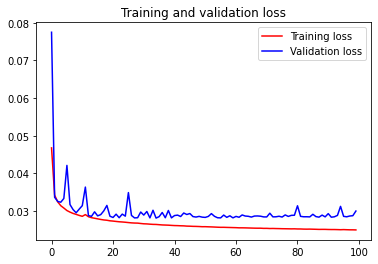

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Error calculation

In [ ]:
import math

reconstr_error = autoencoder.evaluate( x_test, x_test, verbose=0)
print('The reconstruction error: MSE - %.4f, RMSE - %.4f ' % (reconstr_error , math.sqrt(reconstr_error)))

The reconstruction error: MSE - 0.0317, RMSE - 0.1781 


#### Predictions

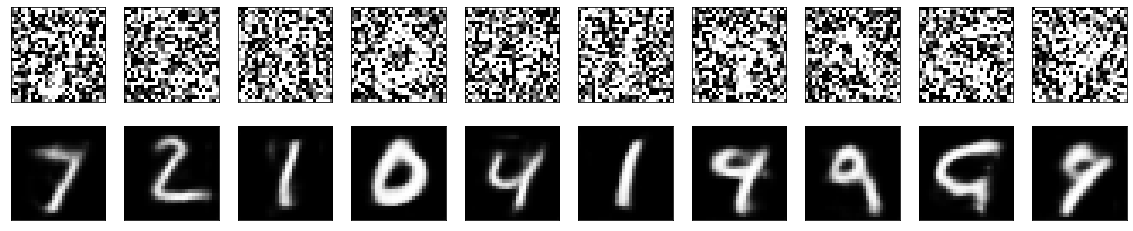

In [ ]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test_noisy[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(autoencoder(x_test_noisy)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Table to compare different arcitectures

| Models | MSE | RMSE | COMMENTS |
| :- | :-:| :-:| :- |
| DENSE MULTI LAYER MODEL 1 | 0.0269 | 0.1640 |  |
| DENSE MULTI LAYER MODEL 2 (L2 Regularizer) | 0.0269 | 0.1640 | |
| CNN Basic Model | 0.0886 | 0.2976 | Prediction image poor when adadelta optimizer used|
| CNN Complex Model | 0.0317| 0.1781 |  |

### REPORT

There were four models listed above for denoising Mnist had written images. Dense multilayer models and CNN with differnt configuration were tried to denoise the data successfully.

Based on the above table, for the denoising task, dense multi layer models outperform the CNN models.

Batch normalization was used sfter the convolution in the encoder and decoder for CNN complex model to improve the perfoemance.

For the two dense multi layer model implementation there is no significant difference in the results, even when L2 regularization is used for model 2.

The best result was produced by the dense multilayer model.

## 3. Text Reconstruction Application



In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import os
from pathlib import Path
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input, BatchNormalization,LeakyReLU
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split

np.random.seed(111)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

### Load Images

Data Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
input_dir  = Path('/content/drive/MyDrive/Colab Notebooks/')
train = input_dir / 'train'
train_cleaned = input_dir / 'train_cleaned'
test = input_dir / 'test'

train_images = sorted(os.listdir(train))
train_labels = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))

In [ ]:
X = []
Y = []

for img in train_images:
    img = load_img(train / img, color_mode = "grayscale", target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(train_cleaned / img, color_mode = "grayscale", target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)

X = np.array(X)
Y = np.array(Y)


# Split the dataset into training and validation. Always set the random state!!
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


### Dense multi-layer model

We will flatten the examples from 420 by 540 arrays to 226800-dimensional vectors.

In [ ]:
X_train_d = np.reshape(X_train, (X_train.shape[0], 226800))
X_valid_d = np.reshape(X_valid, (X_valid.shape[0], 226800))
y_train_d = np.reshape(y_train, (y_train.shape[0], 226800))
y_valid_d = np.reshape(y_valid, (y_valid.shape[0], 226800))

##### Autocencoder

In [ ]:
# Lets' define our autoencoder now
def build_autoenocder():
    input_img = Input(shape=(226800,))

    #enoder
    x = Dense(512, activation='relu')(input_img)
    # x = Dense(64, activation='relu')(x)
     
           
    #decoder
    x = Dense(512, activation='relu')(x)
    decoded = Dense(226800, activation='sigmoid')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='adam' , loss='mse') # Adam(learning_rate=1e-2)
    return autoencoder

autoencoder = build_autoenocder()
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 226800)]          0         
_________________________________________________________________
dense (Dense)                (None, 512)               116122112 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 226800)            116348400 
Total params: 232,733,168
Trainable params: 232,733,168
Non-trainable params: 0
_________________________________________________________________


Training Model for 100 epochs with a batch size 20

In [ ]:
# Train model
history = autoencoder.fit(X_train_d, y_train_d, 
                          epochs=100, 
                          batch_size=20, 
                          validation_data=(X_valid_d, y_valid_d))

Epoch 1/100
7/7 [==============================] - 2s 135ms/step - loss: 0.1588 - val_loss: 0.0888
Epoch 2/100
7/7 [==============================] - 1s 75ms/step - loss: 0.0867 - val_loss: 0.0885
Epoch 3/100
7/7 [==============================] - 1s 77ms/step - loss: 0.0871 - val_loss: 0.0885
Epoch 4/100
7/7 [==============================] - 1s 76ms/step - loss: 0.0860 - val_loss: 0.0884
Epoch 5/100
7/7 [==============================] - 1s 76ms/step - loss: 0.0861 - val_loss: 0.0884
Epoch 6/100
7/7 [==============================] - 1s 75ms/step - loss: 0.0868 - val_loss: 0.0884
Epoch 7/100
7/7 [==============================] - 1s 76ms/step - loss: 0.0868 - val_loss: 0.0884
Epoch 8/100
7/7 [==============================] - 1s 74ms/step - loss: 0.0861 - val_loss: 0.0884
Epoch 9/100
7/7 [==============================] - 1s 75ms/step - loss: 0.0874 - val_loss: 0.0885
Epoch 10/100
7/7 [==============================] - 1s 74ms/step - loss: 0.0855 - val_loss: 0.0885
Epoch 11/100
7/7 [

##### In training performance

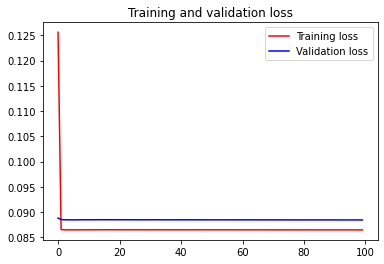

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Error calculation

In [ ]:
import math

reconstr_error = autoencoder.evaluate( X_valid_d, y_valid_d, verbose=0)
print('The reconstruction error: MSE - %.4f, RMSE - %.4f ' % (reconstr_error , math.sqrt(reconstr_error)))

The reconstruction error: MSE - 0.0884, RMSE - 0.2973 


##### Prediction

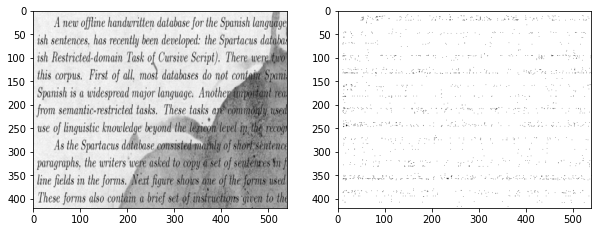

In [ ]:
sample_test = load_img(test/ test_images[0], color_mode = "grayscale", target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.array(sample_test_img)
sample_test_img = np.expand_dims(sample_test, axis=0)

sample_test_img1 = np.reshape(sample_test_img, (sample_test_img.shape[0], 226800 ))


# Compute the prediction
predicted_label = np.squeeze(autoencoder.predict(sample_test_img1))
predicted_label = predicted_label.reshape(420,540)

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test_img[0]), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()

### CNN Basic Models

#### Model 1

##### Autocencoder

In [ ]:
# Lets' define our autoencoder now
def build_autoenocder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #enoder 
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x) 
            
    #decoder
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer= 'adam', loss='mse')
    return autoencoder

autoencoder = build_autoenocder()
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 420, 540, 16)      160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 210, 270, 16)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 210, 270, 8)       1160      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 105, 135, 8)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 105, 135, 8)       584       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 53, 68, 8)         0   

##### Training Model 
For 100 epochs with a batch size 20

In [ ]:
# Train model
history = autoencoder.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=(X_valid, y_valid))

Epoch 1/100
7/7 [==============================] - 6s 506ms/step - loss: 0.2124 - val_loss: 0.1656
Epoch 2/100
7/7 [==============================] - 2s 250ms/step - loss: 0.1402 - val_loss: 0.0749
Epoch 3/100
7/7 [==============================] - 2s 252ms/step - loss: 0.0760 - val_loss: 0.0834
Epoch 4/100
7/7 [==============================] - 2s 248ms/step - loss: 0.0814 - val_loss: 0.0842
Epoch 5/100
7/7 [==============================] - 2s 251ms/step - loss: 0.0824 - val_loss: 0.0843
Epoch 6/100
7/7 [==============================] - 2s 248ms/step - loss: 0.0841 - val_loss: 0.0843
Epoch 7/100
7/7 [==============================] - 2s 249ms/step - loss: 0.0820 - val_loss: 0.0843
Epoch 8/100
7/7 [==============================] - 2s 246ms/step - loss: 0.0825 - val_loss: 0.0843
Epoch 9/100
7/7 [==============================] - 2s 250ms/step - loss: 0.0836 - val_loss: 0.0843
Epoch 10/100
7/7 [==============================] - 2s 253ms/step - loss: 0.0824 - val_loss: 0.0842
Epoch 11/

##### In training performance

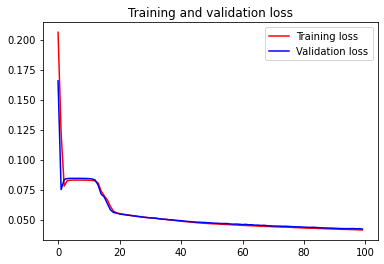

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Error calculation

In [ ]:
import math

reconstr_error = autoencoder.evaluate( X_valid, y_valid, verbose=0)
print('The reconstruction error: MSE - %.4f, RMSE - %.4f ' % (reconstr_error , math.sqrt(reconstr_error)))

The reconstruction error: MSE - 0.0421, RMSE - 0.2051 


##### Prediction

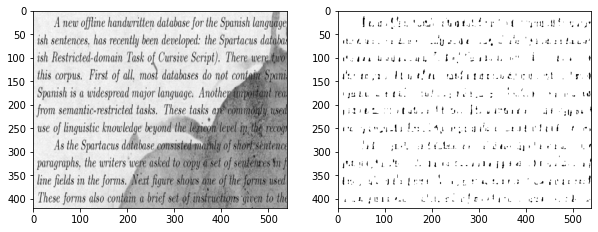

In [ ]:
sample_test = load_img(test/ test_images[0], color_mode = "grayscale", target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Compute the prediction
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test_img[0]), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()

#### Model 2

##### Autocencoder

In [ ]:
# Lets' define our autoencoder now
def build_autoenocder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #enoder 
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
            
    #decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer= 'adam', loss='mse')
    return autoencoder

autoencoder = build_autoenocder()
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 420, 540, 64)      640       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 420, 540, 64)      36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 420, 540, 1)       577       
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train model
history = autoencoder.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=(X_valid, y_valid))

Epoch 1/100
7/7 [==============================] - 26s 3s/step - loss: 0.1375 - val_loss: 0.0603
Epoch 2/100
7/7 [==============================] - 7s 971ms/step - loss: 0.0579 - val_loss: 0.0628
Epoch 3/100
7/7 [==============================] - 7s 981ms/step - loss: 0.0578 - val_loss: 0.0488
Epoch 4/100
7/7 [==============================] - 7s 981ms/step - loss: 0.0436 - val_loss: 0.0369
Epoch 5/100
7/7 [==============================] - 7s 983ms/step - loss: 0.0329 - val_loss: 0.0272
Epoch 6/100
7/7 [==============================] - 7s 988ms/step - loss: 0.0235 - val_loss: 0.0181
Epoch 7/100
7/7 [==============================] - 7s 987ms/step - loss: 0.0161 - val_loss: 0.0132
Epoch 8/100
7/7 [==============================] - 7s 985ms/step - loss: 0.0122 - val_loss: 0.0106
Epoch 9/100
7/7 [==============================] - 7s 989ms/step - loss: 0.0097 - val_loss: 0.0086
Epoch 10/100
7/7 [==============================] - 7s 989ms/step - loss: 0.0079 - val_loss: 0.0071
Epoch 11/10

##### In training performance

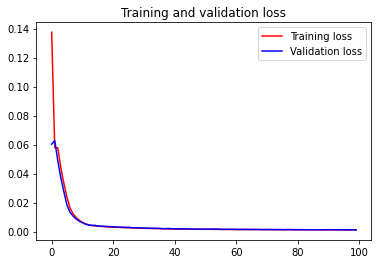

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Error calculation

In [ ]:
import math

reconstr_error = autoencoder.evaluate( X_valid, y_valid, verbose=0)
print('The reconstruction error: MSE - %.4f, RMSE - %.4f ' % (reconstr_error , math.sqrt(reconstr_error)))

The reconstruction error: MSE - 0.0012, RMSE - 0.0348 


##### Prediction

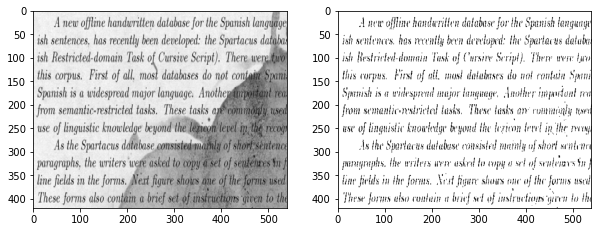

In [ ]:
sample_test = load_img(test/ test_images[0], color_mode = "grayscale", target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Compute the prediction
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test_img[0]), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()

### CNN complex Models

#### Model 1

##### Autocencoder

In [ ]:
# Lets' define our autoencoder now
def build_autoenocder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #enoder 
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
            
    #decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer= 'adam', loss='mse')
    return autoencoder

autoencoder = build_autoenocder()
autoencoder.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 420, 540, 64)      640       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 420, 540, 64)      36928     
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 420, 540, 64)      36928     
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 420, 540, 64)      36928     
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 420, 540, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
____________________________________________________

In [ ]:
# Train model
history = autoencoder.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=(X_valid, y_valid))

Epoch 1/100
7/7 [==============================] - 17s 2s/step - loss: 0.1436 - val_loss: 0.0766
Epoch 2/100
7/7 [==============================] - 17s 2s/step - loss: 0.0737 - val_loss: 0.0581
Epoch 3/100
7/7 [==============================] - 17s 2s/step - loss: 0.0530 - val_loss: 0.0406
Epoch 4/100
7/7 [==============================] - 17s 2s/step - loss: 0.0360 - val_loss: 0.0219
Epoch 5/100
7/7 [==============================] - 17s 2s/step - loss: 0.0190 - val_loss: 0.0126
Epoch 6/100
7/7 [==============================] - 17s 2s/step - loss: 0.0117 - val_loss: 0.0094
Epoch 7/100
7/7 [==============================] - 17s 2s/step - loss: 0.0080 - val_loss: 0.0062
Epoch 8/100
7/7 [==============================] - 17s 2s/step - loss: 0.0060 - val_loss: 0.0058
Epoch 9/100
7/7 [==============================] - 17s 2s/step - loss: 0.0052 - val_loss: 0.0050
Epoch 10/100
7/7 [==============================] - 17s 2s/step - loss: 0.0045 - val_loss: 0.0045
Epoch 11/100
7/7 [===========

##### In training performance

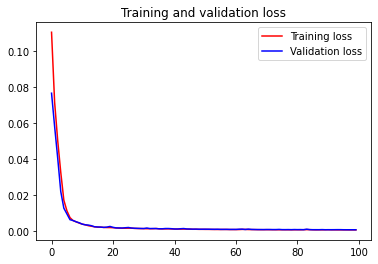

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Error calculation

In [ ]:
import math

reconstr_error = autoencoder.evaluate( X_valid, y_valid, verbose=0)
print('The reconstruction error: MSE - %.4f, RMSE - %.4f ' % (reconstr_error , math.sqrt(reconstr_error)))

The reconstruction error: MSE - 0.0006, RMSE - 0.0247 


##### Prediction

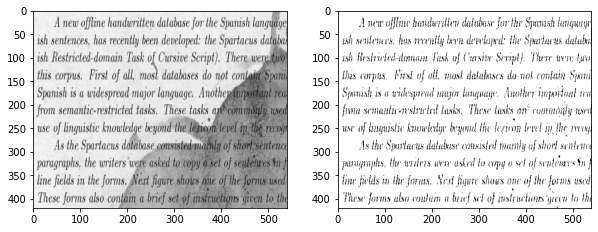

In [ ]:
sample_test = load_img(test/ test_images[0], color_mode = "grayscale", target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Compute the prediction
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test_img[0]), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()

#### Model 2

##### Image Agumentation

In [ ]:
import imgaug as ia
from imgaug import augmenters as iaa

def augment_seq(sequence, images, seed=111):
    ia.seed(seed)
    processed_images = images.copy()
    for step in sequence:
        temp = np.array(step.augment_images(images))
        processed_images = np.append(processed_images, temp, axis=0)
    return(processed_images)

rotate_90 = iaa.Rot90(1) # rotate image 90 degrees
rotate_180 = iaa.Rot90(2) # rotate image 180 degrees
rotate_270 = iaa.Rot90(3) # rotate image 270 degrees
h_flip = iaa.Fliplr(1) # horizontal flips for 100% of images
v_flip = iaa.Flipud(1) # vertical flips for 100% of images


sequence = [ rotate_90, rotate_180, rotate_270, h_flip, v_flip ]

X_train = augment_seq(sequence, X_train)
y_train = augment_seq(sequence, y_train )

X_train.shape, y_train.shape

((774, 420, 540, 1), (774, 420, 540, 1))

##### Autocencoder

In [ ]:
# Lets' define our autoencoder now
def build_autoenocder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #enoder 
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = LeakyReLU(alpha=0.3)(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
            
    #decoder
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer= 'adam', loss='mse')
    return autoencoder

autoencoder = build_autoenocder()
autoencoder.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 420, 540, 32)      320       
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 420, 540, 32)      0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 420, 540, 32)      128       
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 420, 540, 64)      18496     
_________________________________________________________________
leaky_re_lu_55 (LeakyReLU)   (None, 420, 540, 64)      0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 420, 540, 64)      256

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping( monitor='loss', patience=30, verbose=1, restore_best_weights=True )
# Train model
history = autoencoder.fit(X_train, y_train, epochs=100, batch_size=15, validation_data=(X_valid, y_valid))
# history = autoencoder.fit( aug.flow(X_train, y_train, batch_size=20),steps_per_epoch=len(X_train) / 20, 
#                           epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
52/52 [==============================] - 43s 820ms/step - loss: 0.0315 - val_loss: 0.0838
Epoch 2/100
52/52 [==============================] - 42s 802ms/step - loss: 0.0042 - val_loss: 0.0843
Epoch 3/100
52/52 [==============================] - 42s 803ms/step - loss: 0.0031 - val_loss: 0.0844
Epoch 4/100
52/52 [==============================] - 42s 805ms/step - loss: 0.0026 - val_loss: 0.0843
Epoch 5/100
52/52 [==============================] - 42s 805ms/step - loss: 0.0024 - val_loss: 0.0838
Epoch 6/100
52/52 [==============================] - 42s 806ms/step - loss: 0.0022 - val_loss: 0.0817
Epoch 7/100
52/52 [==============================] - 42s 803ms/step - loss: 0.0020 - val_loss: 0.0706
Epoch 8/100
52/52 [==============================] - 42s 802ms/step - loss: 0.0018 - val_loss: 0.0482
Epoch 9/100
52/52 [==============================] - 42s 807ms/step - loss: 0.0017 - val_loss: 0.0233
Epoch 10/100
52/52 [==============================] - 42s 807ms/step - loss: 0.001

##### In training performance

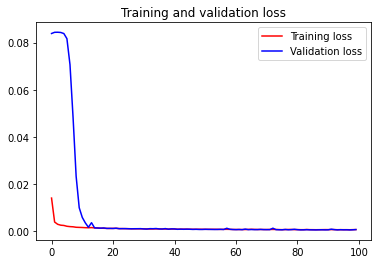

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Error calculation

In [ ]:
import math

reconstr_error = autoencoder.evaluate( X_valid, y_valid, verbose=0)
print('The reconstruction error: MSE - %.4f, RMSE - %.4f ' % (reconstr_error , math.sqrt(reconstr_error)))

The reconstruction error: MSE - 0.0007, RMSE - 0.0260 


##### Prediction

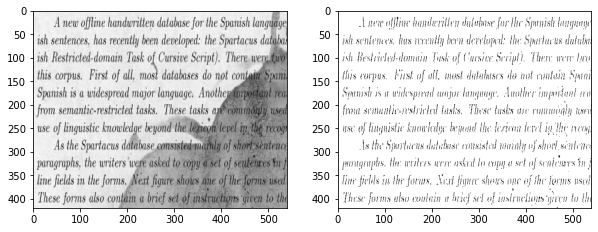

In [ ]:
sample_test = load_img(test/ test_images[0], color_mode = "grayscale", target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Compute the prediction
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test_img[0]), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()

#### Model 3

##### Image Agumentation

In [ ]:
import imgaug as ia
from imgaug import augmenters as iaa

def augment_seq(sequence, images, seed=19):
    ia.seed(seed)
    processed_images = images.copy()
    for step in sequence:
        temp = np.array(step.augment_images(images))
        processed_images = np.append(processed_images, temp, axis=0)
    return(processed_images)

rotate_90 = iaa.Rot90(1) # rotate image 90 degrees
rotate_180 = iaa.Rot90(2) # rotate image 180 degrees
rotate_270 = iaa.Rot90(3) # rotate image 270 degrees
# Skews and transform images without black bg
perc_transform = iaa.PerspectiveTransform(scale=(0.02, 0.1)) 
crop = iaa.Crop(px=(5, 32)) # Crop between 5 to 32 pixels
h_flip = iaa.Fliplr(1) # horizontal flips for 100% of images
v_flip = iaa.Flipud(1) # vertical flips for 100% of images

seq_rp = iaa.Sequential([
    iaa.Rot90((1,3)), # randomly rotate image from 90,180,270 degrees
    iaa.PerspectiveTransform(scale=(0.02, 0.1)) # Skews and transform images without black bg
])

seq_cfg = iaa.Sequential([
    iaa.Crop(px=(5, 32)), # crop images from each side by 5 to 32px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 1.5)) # blur images with a sigma of 0 to 1.5
])

seq_fm = iaa.Sequential([
    iaa.Flipud(1), # vertical flips all the images
    iaa.MotionBlur(k=6) # motion blur images with a kernel size 6
])

sequence = [ rotate_90, rotate_180, rotate_270, perc_transform, crop, h_flip, v_flip, seq_rp, seq_cfg, seq_fm ]

X_train = augment_seq(sequence, X_train)
y_train = augment_seq(sequence, y_train )

X_train.shape, y_train.shape

((1419, 420, 540, 1), (1419, 420, 540, 1))

##### Autocencoder

In [ ]:
# Lets' define our autoencoder now
def build_autoenocder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #enoder 
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
            
    #decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer= 'adam', loss='mse')
    return autoencoder

autoencoder = build_autoenocder()
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 420, 540, 64)      640       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 420, 540, 64)      36928     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 420, 540, 64)      36928     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 420, 540, 64)      36928     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 420, 540, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_____________________________________________________

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping( monitor='loss', verbose=1, restore_best_weights=True )
# Train model
history = autoencoder.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_valid, y_valid))
# history = autoencoder.fit( aug.flow(X_train, y_train, batch_size=20),steps_per_epoch=len(X_train) / 20, 
#                           epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
142/142 [==============================] - 68s 454ms/step - loss: 0.0457 - val_loss: 0.0026
Epoch 2/100
142/142 [==============================] - 64s 449ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 3/100
142/142 [==============================] - 64s 450ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 4/100
142/142 [==============================] - 64s 452ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 5/100
142/142 [==============================] - 64s 453ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 6/100
142/142 [==============================] - 64s 453ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 7/100
142/142 [==============================] - 64s 453ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/100
142/142 [==============================] - 64s 452ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 9/100
142/142 [==============================] - 64s 453ms/step - loss: 0.0014 - val_loss: 8.2607e-04
Epoch 10/100
142/142 [==============================] - 64s 

##### In training performance

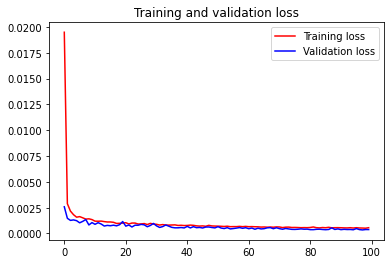

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##### Error calculation

In [ ]:
import math

reconstr_error = autoencoder.evaluate( X_valid, y_valid, verbose=0)
print('The reconstruction error: MSE - %.4f, RMSE - %.4f ' % (reconstr_error , math.sqrt(reconstr_error)))

The reconstruction error: MSE - 0.0004, RMSE - 0.0195 


##### Prediction

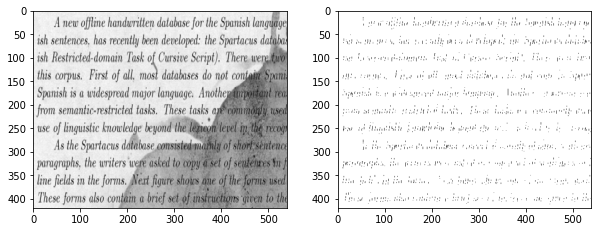

In [ ]:
sample_test = load_img(test/ test_images[0], color_mode = "grayscale", target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Compute the prediction
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test_img[0]), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()

### Table to compare different arcitectures

| Model Architecture | MSE | RMSE | COMMENTS |
| :- | :-:| :-:| :- |
| DENSE MULTI LAYER MODEL | 0.0884 | 0.2973 | Tried with different dense layers in the range 1024 - 32, but the result seems to similar in all the cases |
| CNN Basic Model 1 | 0.0421 | 0.2051 | |
| CNN Basic Model 2 | 0.0012 | 0.0348 | |
| CNN Complex Model 1 | 0.0006 | 0.0247 | |
| CNN Complex Model 2 | 0.0007 | 0.0260 | Applied image augmentation to increase training sample size |
| CNN Complex Model 3 | 0.0004 | 0.0195 |  Applied image augmentation with more parameters to increase training sample size |


### REPORT
From the above experiment we could see the CNN models are performing better in text reconstruction compared to dense multi layer model. 

The performance of dense multi layer model with different dense layers (1024-32)seemed to be similar.

As the model training sample size was small(144), image augmentation has been introduced to increase the training sample size and this yielded better results. 

CNN basic model 2 is performing better than the CNN basic model 1 after removing the max-pooling from the architecture.
The max pooling performance was poor probably due to small sample size.
CNN models seems to have worked better with increased filter size, but the computation cost was higher.

The models were run using Stochastic Gradient Decent and Batch Gradient and the training performance was better with Batch Gradient

All models were run with Relu non-linearity and from the training graphs we can see the learning rate was constant.
In one of the models, CNN Complex Model 2, leaky Relu was introduced as a non-linearity between the layers and the model performed well.

The lowest RMSE that was achieved in this experiment was 0.0195 for the CNN Complex Model 3.

## References

1) Deep Learning with TensorFlow 2 and Keras
By Antonio Gulli, Amita Kapoor, Sujit Pal

https://books.google.ie/books?id=BVnHDwAAQBAJ&pg=PA351&lpg=PA351&dq=def+train(loss,+model,+opt,+original):+with+tf.GradientTape()+as+tape:+preds+%3D+model(original)+reconstruction_error+%3D+loss(preds,+original)+gradients+%3D+tape.gradient(reconstruction_error,+model.trainable_variables)+gradient_variables+%3D+zip(gradients,+model.trainable_variables)+opt.apply_gradients(gradient_variables)+return+reconstruction_error&source=bl&ots=K_sadkTu21&sig=ACfU3U3sncFdDsPOsDeHSjg1JNxJF_Mf4A&hl=en&sa=X&ved=2ahUKEwi_zZ6XyOzvAhW1VBUIHVRAAGkQ6AEwA3oECBAQAw#v=onepage&q&f=false


2) Chollet, F. (2016, May 14). Building Autoencoders in Keras. Retrieved March 19, 2019, from https://blog.keras.io/building-autoencoders-in-keras.html

3)Will Badr (Apr 22, 2019). Auto-Encoder: What Is It? And What Is It Used For? https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726

4) Lucas Robinet(Nov 18, 2020). Data Augmentation and Handling Huge Datasets with Keras: A Simple Way 
https://towardsdatascience.com/data-augmentation-and-handling-huge-datasets-with-keras-a-simple-way-240481069376

5) Jason Brownlee (April 12, 2019). How to Configure Image Data Augmentation in Keras
https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

6) Kayo Yin (Jul 30, 2019). Cleaning Up Dirty Scanned Documents with Deep Learning 
https://medium.com/illuin/cleaning-up-dirty-scanned-documents-with-deep-learning-2e8e6de6cfa6

7) Renu Khandelwal (Dec 11, 2019). Data Augmentation techniques in python
https://towardsdatascience.com/data-augmentation-techniques-in-python-f216ef5eed69





